<a href="https://colab.research.google.com/github/alawrence30/Deep-Learning/blob/main/Assignment_02_v1%20-%20Experiments%205.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>






<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 02 - Part 1
<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div><br>

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

<div class="alert alert-block alert-info">
<b>The CIFAR-10 dataset</b><br>
https://www.cs.toronto.edu/~kriz/cifar.html
    </div>

## Imports

In [1]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Verify TensorFlow Version and Keras Version

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.2


In [4]:
print("Keras version: ", keras.__version__)

Keras version:  2.9.0


## Mount Google Drive to Colab environment

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## EDA Functions

In [6]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [7]:
def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

## Research Assignment Reporting Functions

In [8]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

In [9]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [10]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Loading cifar10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.<br>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


In [11]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of color image data with shapes (num_samples, 32, 32).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)

## EDA Training and Test Datasets

* Imported 50000 examples for training and 10000 examples for test 
* Imported 50000 labels for training and 10000 labels for test 

In [12]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


## Review Labels 

In [13]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


## Plot Subset of Examples

In [14]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [15]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

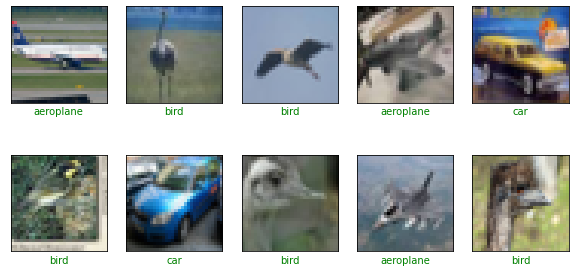

In [16]:
class_names_preview = ['aeroplane', 'car', 'bird']

show_random_examples(x_preview, y_preview, y_preview)

## Preprocessing Data for Model Development

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [17]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

## Create Validation Data Set

In [18]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

## Confirm Datasets {Train, Validation, Test}

In [19]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


## Rescale Examples  {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255
 

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [20]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

print(x_train_norm.shape, x_valid_norm.shape, x_test_norm.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


## Create the Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/CNN_architecture_v4.png?raw=1">


##Experiment 1: DNN with 2 layers (no regularization)

Hidden layer 1: 100 neurons

Hidden layer 2: 150 neurons

Ouput layer: 10 neurons (one for each image)

####Build, Compile, Train, Evaluate

In [21]:
## Variation 1 - did not train
#model_1 = Sequential()
#model_1.add(Dense(input_shape = [32,32,3], units = 100, activation = 'relu', ))
#model_1.add(Dense(units = 150, activation = 'relu'))
#model_1.add(Dense(name = "output_layer", units = 10, activation = 'softmax'))
#model_1.summary()

In [22]:
## Variation 2 - trained 
from time import perf_counter 
model_1 = Sequential()
model_1.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_1.add(layers.Dense(units = 100, activation = "relu"))
model_1.add(layers.Dense(units = 150, activation = "relu"))
model_1.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 100)               307300    
                                                                 
 dense_1 (Dense)             (None, 150)               15150     
                                                                 
 output_layer (Dense)        (None, 10)                1510      
                                                                 
Total params: 323,960
Trainable params: 323,960
Non-trainable params: 0
_________________________________________________________________


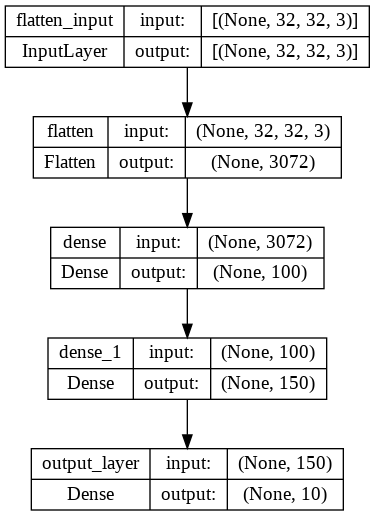

In [23]:
keras.utils.plot_model(model_1, "CIFAR_model.png", show_shapes=True) 

In [24]:
## Compile

model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [25]:
## Train 
time = perf_counter()

history_1 = model_1.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_1.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 5s 4ms/step - loss: 1.8758 - accuracy: 0.3262 - val_loss: 1.7566 - val_accuracy: 0.3690
Epoch 2/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6840 - accuracy: 0.3981 - val_loss: 1.6855 - val_accuracy: 0.3972
Epoch 3/200
704/704 [==============================] - 3s 4ms/step - loss: 1.6143 - accuracy: 0.4276 - val_loss: 1.6263 - val_accuracy: 0.4254
Epoch 4/200
704/704 [==============================] - 3s 4ms/step - loss: 1.5639 - accuracy: 0.4418 - val_loss: 1.6052 - val_accuracy: 0.4190
Epoch 5/200
704/704 [==============================] - 3s 4ms/step - loss: 1.5288 - accuracy: 0.4541 - val_loss: 1.5540 - val_accuracy: 0.4434
Epoch 6/200
704/704 [==============================] - 2s 4ms/step - loss: 1.5006 - accuracy: 0.4632 - val_loss: 1.5628 - val_accuracy: 0.4422
Epoch 7/200
704/704 [==============================] - 3s 4ms/step - loss: 1.4773 - accuracy: 0.4722 - val_loss: 1.5744 - val_accuracy: 0.4304

In [26]:
time_1 = perf_counter() - time
print(time_1)

24.095082012000148


In [27]:
## Evaluate

model_1 = tf.keras.models.load_model("DNN_model_1.h5")
print(f"Test acc: {model_1.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 1.5282 - accuracy: 0.4606
Test acc: 0.461


##Experiment 2: DNN with 3 layers (no regularization)

Hidden layer 1: 100

Hidden layer 2: 150

Hidden layer 3: 75

Output layer: 10 (one for each image)

#### Build, Compile, Train, Evaluate

In [28]:
model_2 = Sequential()
model_2.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_2.add(layers.Dense(units = 100, activation = "relu"))
model_2.add(layers.Dense(units = 250, activation = "relu"))
model_2.add(layers.Dense(units = 150, activation = "relu"))
model_2.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               307300    
                                                                 
 dense_3 (Dense)             (None, 250)               25250     
                                                                 
 dense_4 (Dense)             (None, 150)               37650     
                                                                 
 output_layer (Dense)        (None, 10)                1510      
                                                                 
Total params: 371,710
Trainable params: 371,710
Non-trainable params: 0
_________________________________________________________________


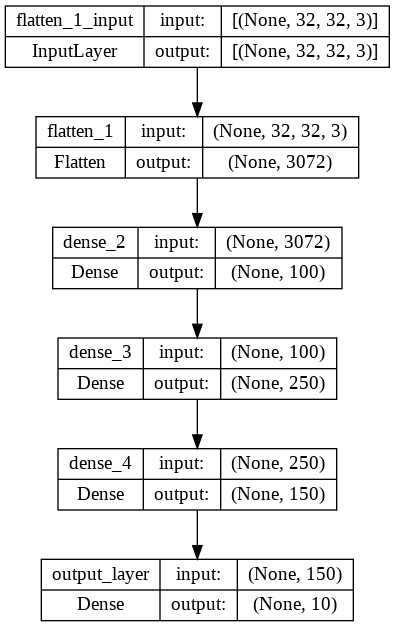

In [29]:
keras.utils.plot_model(model_2, "CIFAR_model.png", show_shapes=True) 

In [30]:
## Compile

model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [31]:
## Train 
time = perf_counter()

history_2 = model_2.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_2.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 4ms/step - loss: 1.8612 - accuracy: 0.3239 - val_loss: 1.7494 - val_accuracy: 0.3660
Epoch 2/200
704/704 [==============================] - 3s 4ms/step - loss: 1.6847 - accuracy: 0.3927 - val_loss: 1.6920 - val_accuracy: 0.3830
Epoch 3/200
704/704 [==============================] - 3s 4ms/step - loss: 1.6094 - accuracy: 0.4222 - val_loss: 1.6256 - val_accuracy: 0.4112
Epoch 4/200
704/704 [==============================] - 3s 4ms/step - loss: 1.5568 - accuracy: 0.4405 - val_loss: 1.6452 - val_accuracy: 0.4082
Epoch 5/200
704/704 [==============================] - 3s 4ms/step - loss: 1.5132 - accuracy: 0.4578 - val_loss: 1.5540 - val_accuracy: 0.4350
Epoch 6/200
704/704 [==============================] - 3s 4ms/step - loss: 1.4766 - accuracy: 0.4726 - val_loss: 1.5389 - val_accuracy: 0.4508
Epoch 7/200
704/704 [==============================] - 3s 4ms/step - loss: 1.4535 - accuracy: 0.4782 - val_loss: 1.5331 - val_accuracy: 0.4428

In [32]:
time_2 = perf_counter() - time
print(time_2)

83.30458461799981


In [33]:
## Evaluate

model_2 = tf.keras.models.load_model("DNN_model_2.h5")
print(f"Test acc: {model_2.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 1.4618 - accuracy: 0.4822
Test acc: 0.482


##Experiment 3: CNN with 2 convolution/max pooling layers (no regularization)

Layer 1: 128

Layer 2: 256

Layer: 384

#### Build, Compile, Train, Evaluate

In [34]:
## Build CNN

model_3 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]), # Layer 1 start
  MaxPool2D((2, 2),strides=2), # Layer 1 end
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), # Layer 2 start
  MaxPool2D((2, 2),strides=2), # Layer 2 end
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # Classification 
  Dense(units=10, activation=tf.nn.softmax)       
])

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 9216)              0         
                                                                 
 dense_5 (Dense)             (None, 384)              

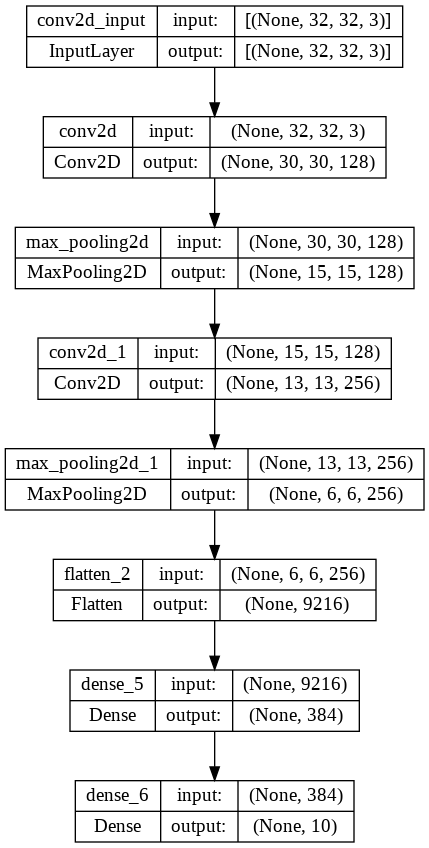

In [35]:
keras.utils.plot_model(model_3, "CIFAR10.png", show_shapes=True) 

In [36]:
## Compile

model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [37]:
## Train 
time = perf_counter()

history_3 = model_3.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_3.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 14s 11ms/step - loss: 2.1593 - accuracy: 0.1964 - val_loss: 2.0229 - val_accuracy: 0.2196
Epoch 2/200
704/704 [==============================] - 8s 11ms/step - loss: 1.9655 - accuracy: 0.2355 - val_loss: 1.9116 - val_accuracy: 0.2440
Epoch 3/200
704/704 [==============================] - 8s 11ms/step - loss: 1.8338 - accuracy: 0.3013 - val_loss: 1.7833 - val_accuracy: 0.3064
Epoch 4/200
704/704 [==============================] - 8s 11ms/step - loss: 1.7193 - accuracy: 0.3362 - val_loss: 1.7104 - val_accuracy: 0.3170
Epoch 5/200
704/704 [==============================] - 8s 11ms/step - loss: 1.6316 - accuracy: 0.3556 - val_loss: 1.6207 - val_accuracy: 0.3506
Epoch 6/200
704/704 [==============================] - 8s 12ms/step - loss: 1.5605 - accuracy: 0.3730 - val_loss: 1.5450 - val_accuracy: 0.3670
Epoch 7/200
704/704 [==============================] - 8s 11ms/step - loss: 1.4887 - accuracy: 0.3981 - val_loss: 1.4932 - val_accuracy

In [38]:
time_3 = perf_counter() - time
print(time_3)

261.1797233399998


In [39]:
## Evaluate

model_3 = tf.keras.models.load_model("CNN_model_3.h5")
print(f"Test acc: {model_3.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 4ms/step - loss: 1.1906 - accuracy: 0.6151
Test acc: 0.615


##Experiment 4: CNN with 2 convolution/max pooling layers (no regularization)

Layer 1: 128

Layer 2: 256

Layer 3: 512

Layer: 384

#### Build, Compile, Train, Evaluate

In [40]:
## Build CNN

model_4 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]), #Start of Layer 1
  MaxPool2D((2, 2),strides=2), #End of Layer 1
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), #Start of Layer 2
  MaxPool2D((2, 2),strides=2), #End of Layer 2
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), #Start of Layer 3
  MaxPool2D((2, 2),strides=2), #End of Layer 3
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # Classification
  BatchNormalization(),
  Dense(units=10, activation=tf.nn.softmax)       
])
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 512)         1180160   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 2, 2, 512)       

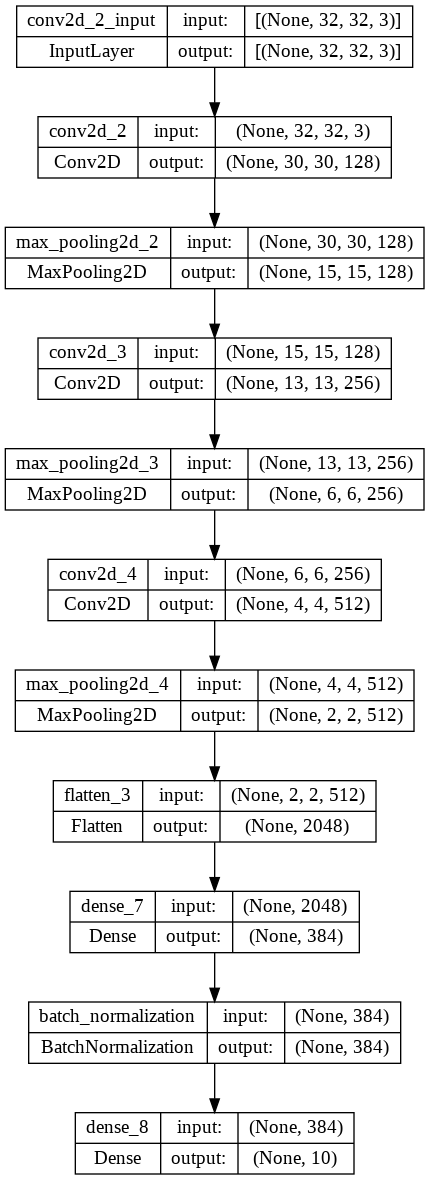

In [41]:
keras.utils.plot_model(model_4, "CIFAR10.png", show_shapes=True) 

In [42]:
## Compile
model_4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [43]:
## Train
time = perf_counter()

history_4 = model_4.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_4.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 10s 13ms/step - loss: 1.5190 - accuracy: 0.4716 - val_loss: 1.2913 - val_accuracy: 0.5514
Epoch 2/200
704/704 [==============================] - 9s 13ms/step - loss: 1.0919 - accuracy: 0.6355 - val_loss: 1.0622 - val_accuracy: 0.6412
Epoch 3/200
704/704 [==============================] - 9s 13ms/step - loss: 0.9004 - accuracy: 0.7086 - val_loss: 0.9914 - val_accuracy: 0.6744
Epoch 4/200
704/704 [==============================] - 10s 14ms/step - loss: 0.7796 - accuracy: 0.7526 - val_loss: 0.9957 - val_accuracy: 0.6904
Epoch 5/200
704/704 [==============================] - 9s 13ms/step - loss: 0.6735 - accuracy: 0.7931 - val_loss: 0.8442 - val_accuracy: 0.7430
Epoch 6/200
704/704 [==============================] - 9s 13ms/step - loss: 0.5831 - accuracy: 0.8261 - val_loss: 0.9447 - val_accuracy: 0.7174
Epoch 7/200
704/704 [==============================] - 9s 13ms/step - loss: 0.5075 - accuracy: 0.8532 - val_loss: 0.9459 - val_accurac

In [44]:
time_4 = perf_counter() - time
print(time_4)

76.43121569100003


In [45]:
## Evalute

model_4 = tf.keras.models.load_model("CNN_model_4.h5")
print(f"Test acc: {model_4.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 5ms/step - loss: 0.8607 - accuracy: 0.7442
Test acc: 0.744


##Experiment 5: Experiments 1-4 with regularization 
https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/

#### Model 5.1.3 - BEST MODEL for 1

Same as Model 5.1.2 with regularization - Dropout (0.10) + added layer (250 nodes) + output activation = sigmoid

In [46]:
## Build
from keras import regularizers
from keras.layers.core import Dropout

model_5_13 = Sequential()
model_5_13.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_13.add(layers.Dense(units = 550, activation = "relu"))
model_5_13.add(Dropout(0.1))
model_5_13.add(layers.Dense(units = 300, activation = "relu"))
model_5_13.add(Dropout(0.1))
model_5_13.add(layers.Dense(units = 250, activation = "relu"))
model_5_13.add(Dropout(0.1))
model_5_13.add(layers.Dense(name = "output_layer", units = 10, activation = "sigmoid"))

model_5_13.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 3072)              0         
                                                                 
 dense_9 (Dense)             (None, 550)               1690150   
                                                                 
 dropout (Dropout)           (None, 550)               0         
                                                                 
 dense_10 (Dense)            (None, 300)               165300    
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_11 (Dense)            (None, 250)               75250     
                                                                 
 dropout_2 (Dropout)         (None, 250)              

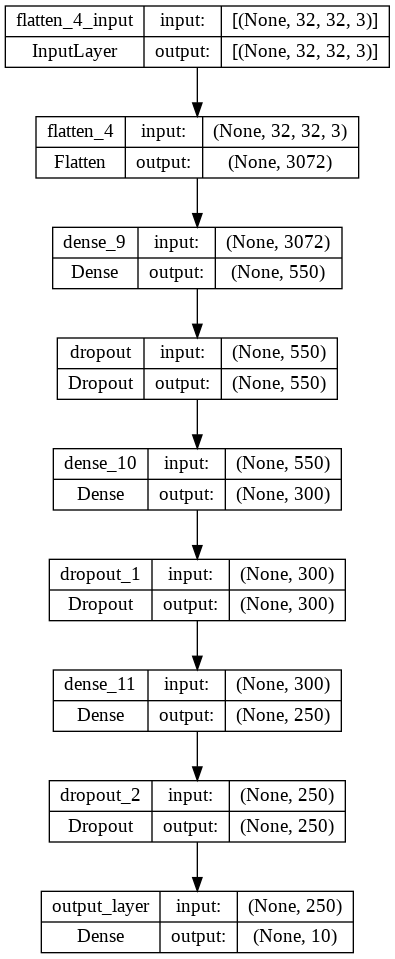

In [47]:
keras.utils.plot_model(model_5_13, "CIFAR_model.png", show_shapes=True) 

In [48]:
## Compile

model_5_13.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [49]:
## Train 
time = perf_counter()

history_5_13 = model_5_13.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_13.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 4s 5ms/step - loss: 1.9473 - accuracy: 0.2877 - val_loss: 1.8766 - val_accuracy: 0.3074
Epoch 2/200
704/704 [==============================] - 3s 4ms/step - loss: 1.7863 - accuracy: 0.3549 - val_loss: 1.7099 - val_accuracy: 0.3742
Epoch 3/200
704/704 [==============================] - 3s 4ms/step - loss: 1.7239 - accuracy: 0.3768 - val_loss: 1.6793 - val_accuracy: 0.3926
Epoch 4/200
704/704 [==============================] - 3s 4ms/step - loss: 1.6758 - accuracy: 0.3950 - val_loss: 1.6385 - val_accuracy: 0.4026
Epoch 5/200
704/704 [==============================] - 3s 4ms/step - loss: 1.6416 - accuracy: 0.4101 - val_loss: 1.6156 - val_accuracy: 0.4214
Epoch 6/200
704/704 [==============================] - 3s 4ms/step - loss: 1.6182 - accuracy: 0.4190 - val_loss: 1.5442 - val_accuracy: 0.4472
Epoch 7/200
704/704 [==============================] - 3s 4ms/step - loss: 1.5925 - accuracy: 0.4254 - val_loss: 1.5509 - val_accuracy: 0.4344

In [50]:
time_5_13 = perf_counter() - time
print(time_5_13)

29.032604876999812


In [51]:
## Evaluate

model_5_13 = tf.keras.models.load_model("DNN_model_5_13.h5")
print(f"Test acc: {model_5_13.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 1.5213 - accuracy: 0.4539
Test acc: 0.454


#### Model 5.2.2 - BEST MODEL 2, tied with 5.2.3

Same as Model 5.2.1 with bais regularization L2, updated nodes (550, 300, 250)

In [52]:
from keras.regularizers import l2

model_5_22 = Sequential()
model_5_22.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_22.add(layers.Dense(units = 550, activation = "relu", bias_regularizer=l2(0.01)))
model_5_22.add(layers.Dense(units = 300, activation = "relu", bias_regularizer=l2(0.01)))
model_5_22.add(layers.Dense(units = 250, activation = "relu", bias_regularizer=l2(0.01)))
model_5_22.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_5_22.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 3072)              0         
                                                                 
 dense_12 (Dense)            (None, 550)               1690150   
                                                                 
 dense_13 (Dense)            (None, 300)               165300    
                                                                 
 dense_14 (Dense)            (None, 250)               75250     
                                                                 
 output_layer (Dense)        (None, 10)                2510      
                                                                 
Total params: 1,933,210
Trainable params: 1,933,210
Non-trainable params: 0
_________________________________________________________________


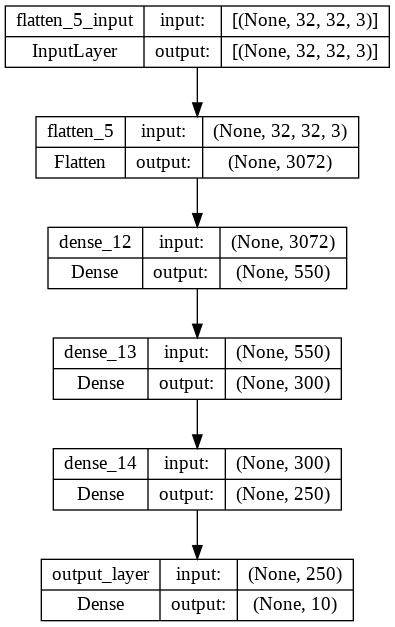

In [53]:
keras.utils.plot_model(model_5_22, "CIFAR_model.png", show_shapes=True) 

In [54]:
## Compile

model_5_22.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [55]:
## Train 
time = perf_counter()

history_5_22 = model_5_22.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_22.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 4s 5ms/step - loss: 1.8909 - accuracy: 0.3115 - val_loss: 1.8015 - val_accuracy: 0.3518
Epoch 2/200
704/704 [==============================] - 3s 4ms/step - loss: 1.6929 - accuracy: 0.3934 - val_loss: 1.7607 - val_accuracy: 0.3624
Epoch 3/200
704/704 [==============================] - 3s 4ms/step - loss: 1.6046 - accuracy: 0.4259 - val_loss: 1.6446 - val_accuracy: 0.4012
Epoch 4/200
704/704 [==============================] - 3s 4ms/step - loss: 1.5462 - accuracy: 0.4473 - val_loss: 1.5759 - val_accuracy: 0.4412
Epoch 5/200
704/704 [==============================] - 3s 4ms/step - loss: 1.5004 - accuracy: 0.4640 - val_loss: 1.6055 - val_accuracy: 0.4368
Epoch 6/200
704/704 [==============================] - 3s 4ms/step - loss: 1.4625 - accuracy: 0.4793 - val_loss: 1.5212 - val_accuracy: 0.4542
Epoch 7/200
704/704 [==============================] - 3s 4ms/step - loss: 1.4320 - accuracy: 0.4887 - val_loss: 1.5676 - val_accuracy: 0.4432

In [56]:
time_5_22 = perf_counter() - time
print(time_5_22)

38.669264830999964


In [57]:
## Evaluate

model_5_22 = tf.keras.models.load_model("DNN_model_5_22.h5")
print(f"Test acc: {model_5_22.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 1.4463 - accuracy: 0.4918
Test acc: 0.492


##### Plot Metrics

In [58]:
history_dict_5_22 = history_5_22.history
history_dict_5_22.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [59]:
history_df_5_22=pd.DataFrame(history_dict_5_22)
history_df_5_22.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
7,1.397,0.500,1.493,0.468
8,1.370,0.512,1.480,0.475
9,1.343,0.521,1.517,0.460
10,1.314,0.529,1.483,0.471
11,1.287,0.539,1.501,0.460


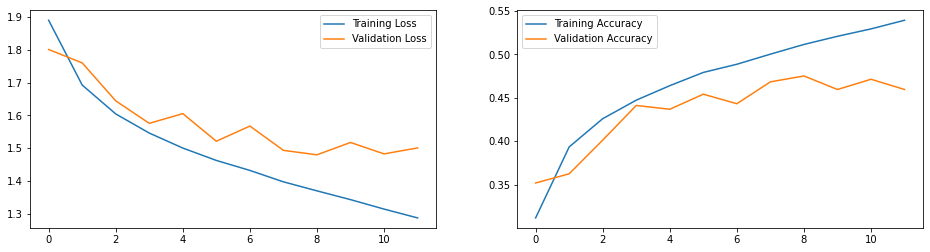

In [60]:
## Loss and acuracy
plot_history(history_5_22)

In [61]:
## Confusion matrix
pred_5_22= model_5_22.predict(x_test_norm)
pred_5_22=np.argmax(pred_5_22, axis=1)

313/313 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step


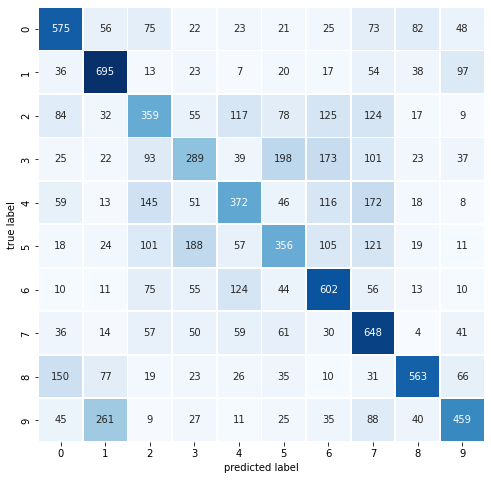

In [62]:
# Get the predicted classes:
pred_classes_5_22 = np.argmax(model_5_22.predict(x_test_norm), axis=-1)
pred_classes_5_22;

conf_mx_5_22 = tf.math.confusion_matrix(y_test, pred_classes_5_22)
conf_mx_5_22;

plot_confusion_matrix(y_test,pred_classes_5_22)

##### Activation and Performance

In [63]:
# Extracts the outputs of all layers:
layer_outputs_5_22 = [layer.output for layer in model_5_22.layers]

# Creates a model that will return these outputs, given the model input:
activation_model_5_22 = models.Model(inputs=model_5_22.input, outputs=layer_outputs_5_22)

# Get activation values for the last dense layer
activations_5_22 = activation_model_5_22.predict(x_valid_norm[:3250])
dense_layer_activations_5_22 = activations_5_22[-3]
output_layer_activations_5_22 = activations_5_22[-1]

102/102 [==============================] - 0s 2ms/step


In [64]:
## TSNE
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_5_22 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_5_22 = tsne_5_22.fit_transform(dense_layer_activations_5_22)

# Scaling
tsne_results_5_22 = (tsne_results_5_22 - tsne_results_5_22.min()) / (tsne_results_5_22.max() - tsne_results_5_22.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.001s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 3250 samples in 0.417s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 3.877931
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.081451
[t-SNE] KL divergence after 300 iterations: 2.374238


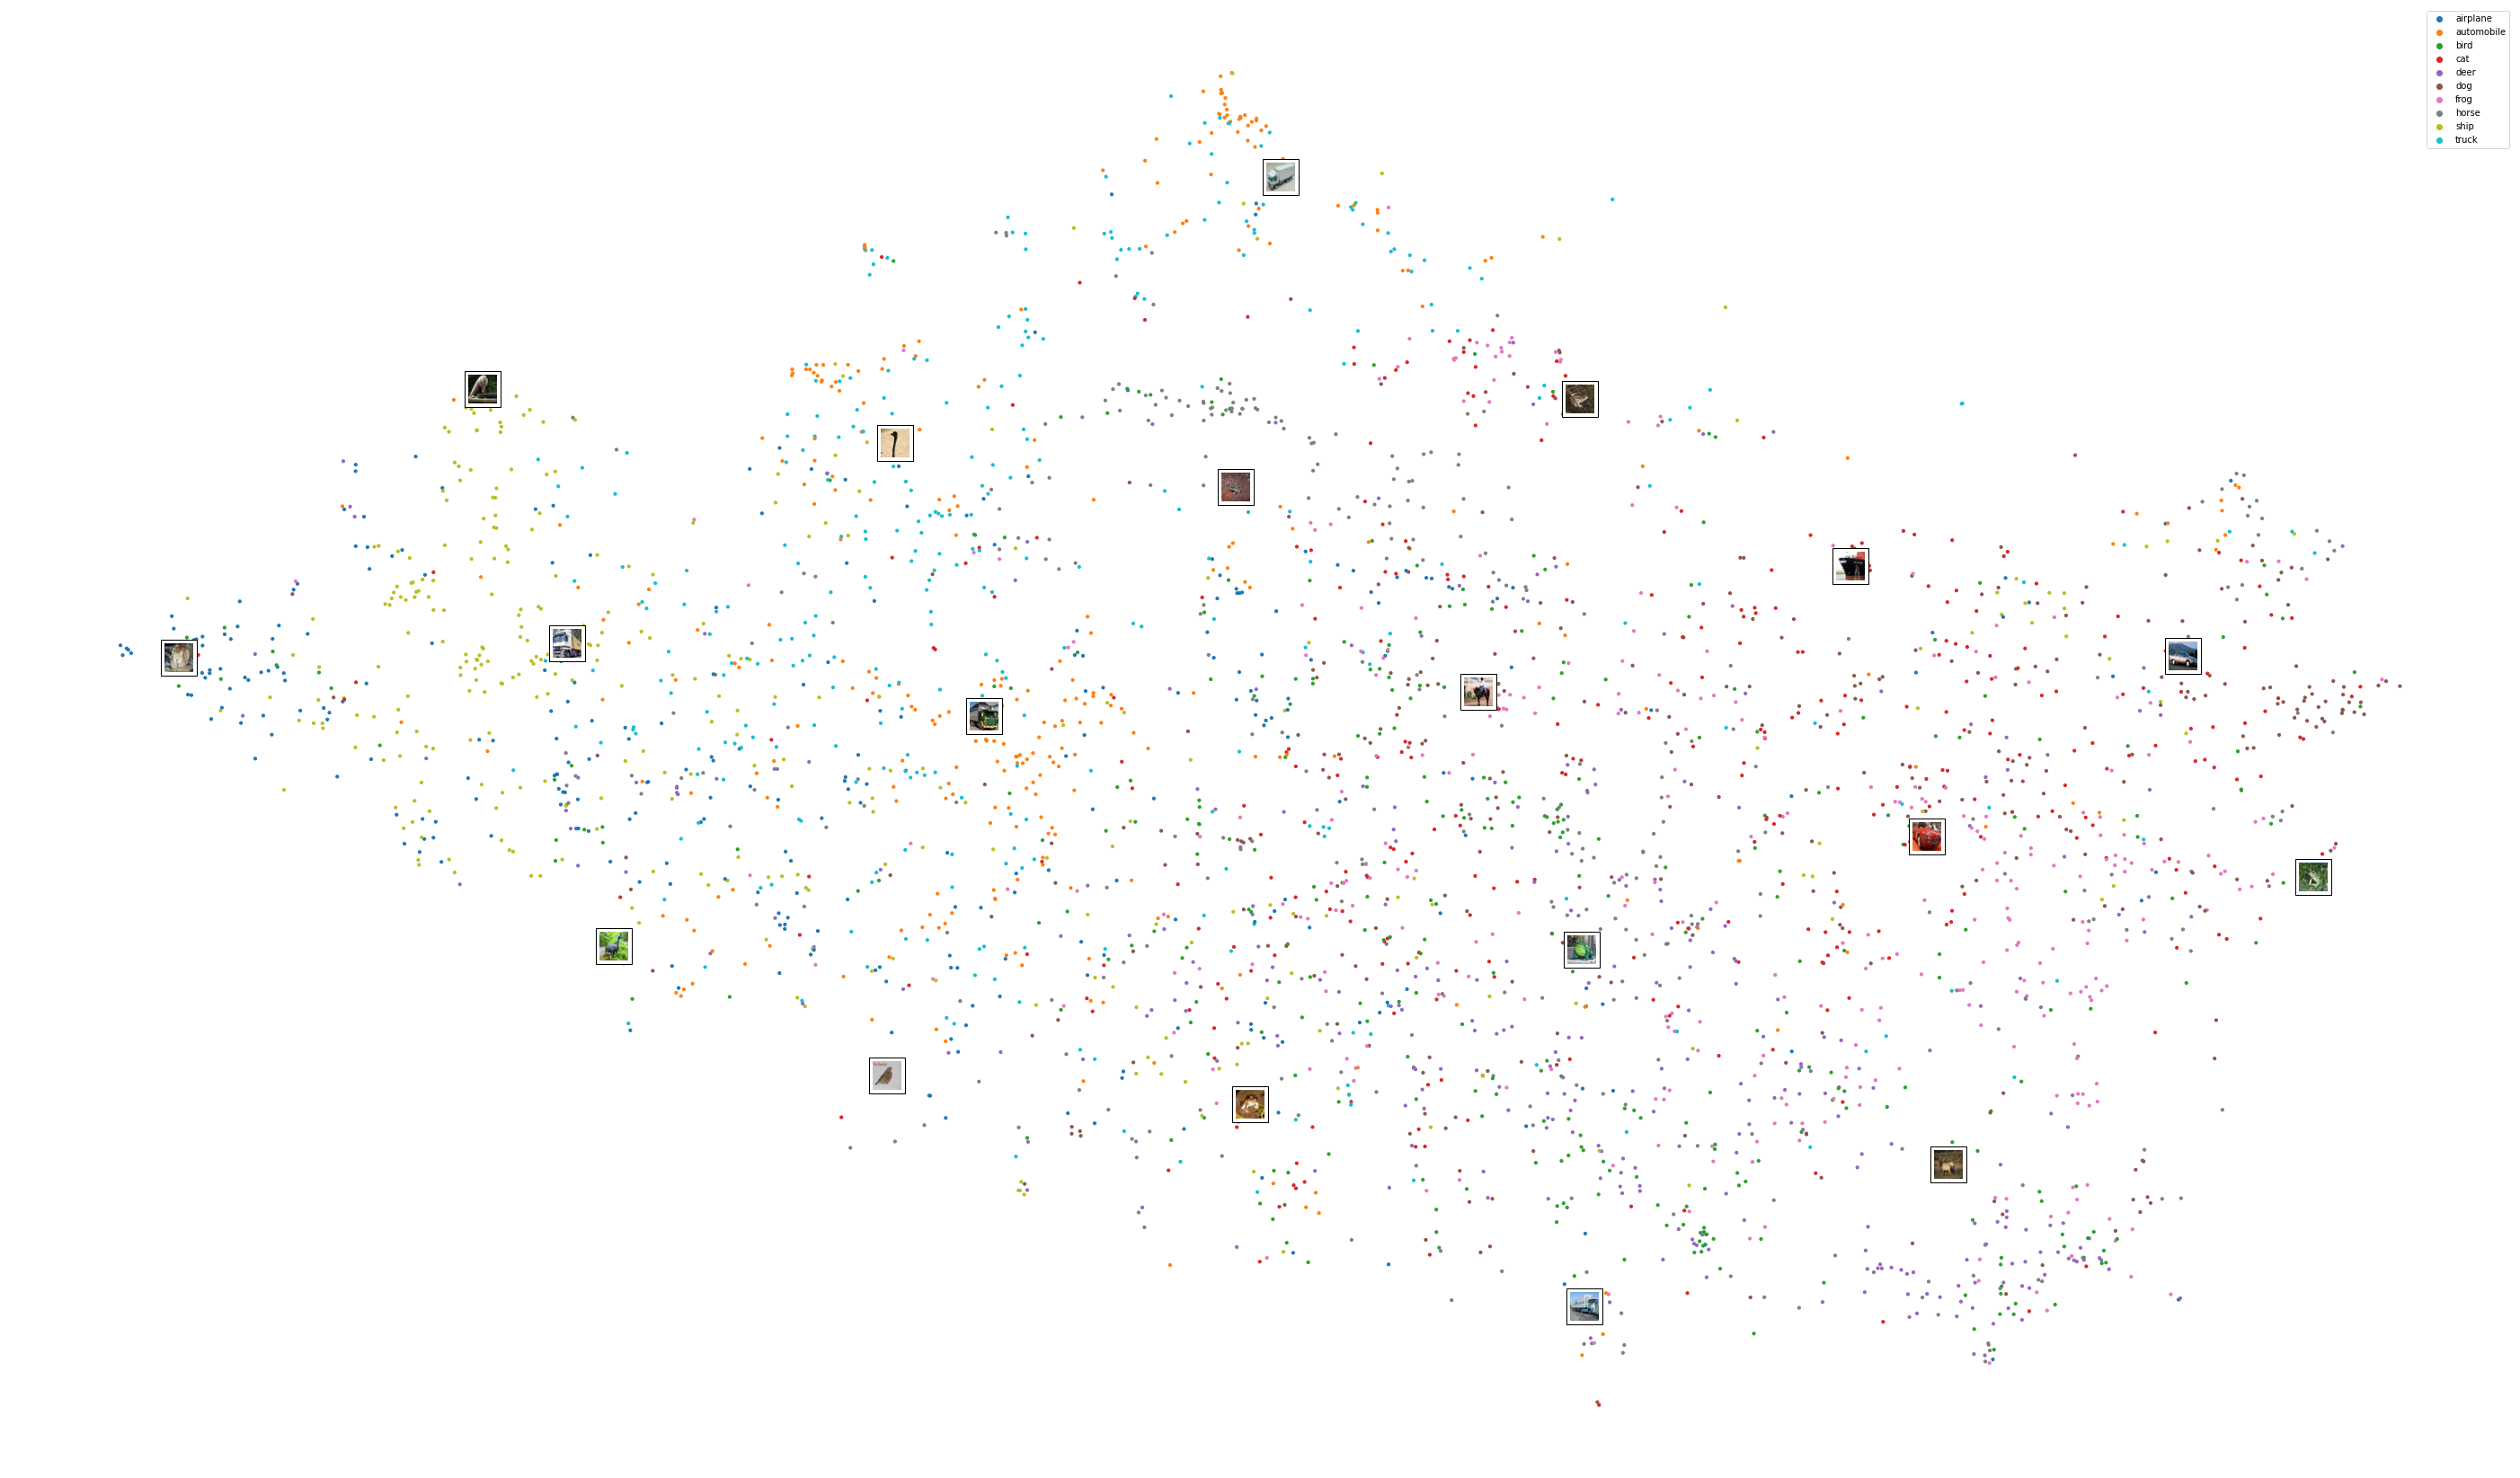

In [65]:
cmap_5_22 = plt.cm.tab10
plt.figure(figsize=(50,30))
scatter_5_22 = plt.scatter(tsne_results_5_22[:,0],tsne_results_5_22[:,1], c=y_valid_split[:3250], s=10, cmap=cmap_5_22)
plt.legend(handles=scatter_5_22.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_5_22):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

##### Predictions

In [66]:
model_5_22 = tf.keras.models.load_model('DNN_model_5_22.h5')
preds_5_22 = model_5_22.predict(x_test_norm)
preds_5_22.shape

313/313 [==============================] - 1s 2ms/step


(10000, 10)

In [67]:
cm_5_22 = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [68]:
df_5_22= pd.DataFrame(preds_5_22[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df_5_22.style.format("{:.2%}").background_gradient(cmap=cm_5_22)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,4.04%,9.10%,4.20%,35.49%,5.95%,27.27%,6.14%,0.81%,4.63%,2.37%
1,3.69%,37.15%,0.12%,0.01%,0.02%,0.01%,0.01%,0.03%,13.07%,45.90%
2,16.89%,33.90%,0.36%,0.12%,0.16%,0.10%,0.00%,0.38%,35.87%,12.20%
3,50.60%,5.93%,6.77%,0.81%,2.74%,1.20%,0.03%,14.88%,13.04%,4.01%
4,0.20%,0.01%,1.98%,1.01%,88.62%,1.45%,6.10%,0.58%,0.04%,0.00%
5,1.39%,0.33%,4.77%,14.49%,6.50%,5.68%,64.90%,1.80%,0.03%,0.12%
6,2.71%,60.84%,0.87%,22.85%,0.01%,9.81%,0.82%,0.60%,0.68%,0.81%
7,2.05%,0.34%,32.85%,7.99%,20.10%,7.03%,22.90%,5.74%,0.51%,0.49%
8,8.11%,0.06%,40.52%,6.45%,12.01%,6.15%,0.82%,25.68%,0.18%,0.03%
9,0.18%,84.35%,0.65%,0.46%,0.01%,0.15%,0.05%,0.12%,0.64%,13.40%


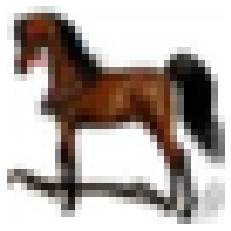

In [69]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img_5_22 = test_images[2004]
img_tensor_5_22 = image.img_to_array(img_5_22)
img_tensor_5_22 = np.expand_dims(img_tensor_5_22, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img_5_22, cmap='viridis')
plt.axis('off')
plt.show()

In [70]:
# Extracts the outputs of the top 8 layers:
layer_outputs_5_22 = [layer.output for layer in model_5_22.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model_5_22 = models.Model(inputs=model_5_22.input, outputs=layer_outputs_5_22)

In [71]:
activations_5_22 = activation_model_5_22.predict(img_tensor_5_22)
len(activations_5_22)

1/1 [==============================] - 0s 79ms/step


5

In [72]:
layer_names = []
for layer in model_5_22.layers:
    layer_names.append(layer.name)
    
layer_names

['flatten_5', 'dense_12', 'dense_13', 'dense_14', 'output_layer']

In [ ]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model_5_22.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations_5_22):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();

#### Model 5.2.3 - BEST MODEL 2, tied with 5.2.2

Same as Model 5.2.2 with dropout - 0.1 + output activation = sigmoid

In [ ]:
from keras.regularizers import l2

model_5_23 = Sequential()
model_5_23.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_23.add(layers.Dense(units = 550, activation = "relu", bias_regularizer=l2(0.01)))
model_5_13.add(Dropout(0.1))
model_5_23.add(layers.Dense(units = 300, activation = "relu", bias_regularizer=l2(0.01)))
model_5_13.add(Dropout(0.1))
model_5_23.add(layers.Dense(units = 250, activation = "relu", bias_regularizer=l2(0.01)))
model_5_13.add(Dropout(0.1))
model_5_23.add(layers.Dense(name = "output_layer", units = 10, activation = "sigmoid"))

model_5_23.summary()

In [ ]:
keras.utils.plot_model(model_5_23, "CIFAR_model.png", show_shapes=True) 

In [ ]:
## Compile

model_5_23.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
## Train 
time = perf_counter()

history_5_23 = model_5_23.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_23.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

In [ ]:
time_5_23 = perf_counter() - time
print(time_5_23)

In [ ]:
## Evaluate

model_5_23 = tf.keras.models.load_model("DNN_model_5_23.h5")
print(f"Test acc: {model_5_23.evaluate(x_test_norm, y_test)[1]:.3f}")

##### Plot Metrics

In [ ]:
history_dict_5_23 = history_5_23.history
history_dict_5_23.keys()

In [ ]:
history_df_5_23=pd.DataFrame(history_dict_5_23)
history_df_5_23.tail().round(3)

In [ ]:
## Loss and acuracy
plot_history(history_5_23)

In [ ]:
## Confusion matrix
pred_5_23= model_5_23.predict(x_test_norm)
pred_5_23=np.argmax(pred_5_23, axis=1)

In [ ]:
# Get the predicted classes:
pred_classes_5_23 = np.argmax(model_5_23.predict(x_test_norm), axis=-1)
pred_classes_5_23;

conf_mx_5_23 = tf.math.confusion_matrix(y_test, pred_classes_5_23)
conf_mx_5_23;

plot_confusion_matrix(y_test,pred_classes_5_23)

##### Activation and Performance

In [ ]:
# Extracts the outputs of all layers:
layer_outputs_5_23 = [layer.output for layer in model_5_23.layers]

# Creates a model that will return these outputs, given the model input:
activation_model_5_23 = models.Model(inputs=model_5_23.input, outputs=layer_outputs_5_23)

# Get activation values for the last dense layer
activations_5_23 = activation_model_5_23.predict(x_valid_norm[:3250])
dense_layer_activations_5_23 = activations_5_23[-3]
output_layer_activations_5_23 = activations_5_23[-1]

In [ ]:
## TSNE
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_5_23 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_5_23 = tsne_5_23.fit_transform(dense_layer_activations_5_23)

# Scaling
tsne_results_5_23 = (tsne_results_5_23 - tsne_results_5_23.min()) / (tsne_results_5_23.max() - tsne_results_5_23.min())

In [ ]:
cmap_5_23 = plt.cm.tab10
plt.figure(figsize=(50,30))
scatter_5_23 = plt.scatter(tsne_results_5_23[:,0],tsne_results_5_23[:,1], c=y_valid_split[:3250], s=10, cmap=cmap_5_23)
plt.legend(handles=scatter_5_23.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_5_23):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

##### Predictions

In [ ]:
model_5_23 = tf.keras.models.load_model('CNN_model_5_23.h5')
preds_5_23 = model_5_23predict(x_test_norm)
preds_5_23.shape

In [ ]:
cm_5_23 = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df_5_23= pd.DataFrame(preds_5_23[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df_5_23.style.format("{:.2%}").background_gradient(cmap=cm_5_23

In [ ]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img_5_23 = test_images[2004]
img_tensor_5_23 = image.img_to_array(img_5_23)
img_tensor_5_23 = np.expand_dims(img_tensor_5_23, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img_5_23, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs_5_23 = [layer.output for layer in model_5_23.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model_5_23 = models.Model(inputs=model_5_23.input, outputs=layer_outputs_5_23)

In [ ]:
activations_5_23 = activation_model_5_23.predict(img_tensor_5_23)
len(activations_5_23)

In [ ]:
layer_names = []
for layer in model_5_23.layers:
    layer_names.append(layer.name)
    
layer_names

In [ ]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model_5_23.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations_5_23):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();

#### Model 5.3.3 - BEST MODEL 3

Same as model 5.3.1 + closeout activation = sigmoid

In [ ]:
## Build CNN

model_5_33 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]), # Layer 1 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.1), # Layer 1 end
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), # Layer 2 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.1), # Layer 2 end
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # Classification 
  Dense(units=10, activation=tf.nn.sigmoid)       
])

model_5_33.summary()

In [ ]:
keras.utils.plot_model(model_5_33, "CIFAR10.png", show_shapes=True) 

In [ ]:
## Compile

model_5_33.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
## Train 
time = perf_counter()

history_5_33 = model_5_33.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_33.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

In [ ]:
time_5_33 = perf_counter() - time
print(time_5_33)

In [ ]:
## Evaluate

model_5_33 = tf.keras.models.load_model("CNN_model_5_33.h5")
print(f"Test acc: {model_5_33.evaluate(x_test_norm, y_test)[1]:.3f}")

##### Plot Metrics

In [ ]:
history_dict_5_33 = history_5_33.history
history_dict_5_33.keys()

In [ ]:
history_df_5_33=pd.DataFrame(history_dict_5_33)
history_df_5_33.tail().round(3)

In [ ]:
## Loss and acuracy
plot_history(history_5_33)

In [ ]:
## Confusion matrix
pred_5_33= model_5_33.predict(x_test_norm)
pred_5_33=np.argmax(pred_5_33, axis=1)

In [ ]:
# Get the predicted classes:
pred_classes_5_33 = np.argmax(model_5_33.predict(x_test_norm), axis=-1)
pred_classes_5_33;

conf_mx_5_33 = tf.math.confusion_matrix(y_test, pred_classes_5_33)
conf_mx_5_33;

plot_confusion_matrix(y_test,pred_classes_5_33)

##### Activation and Performance

In [ ]:
# Extracts the outputs of all layers:
layer_outputs_5_33 = [layer.output for layer in model_5_33.layers]

# Creates a model that will return these outputs, given the model input:
activation_model_5_33 = models.Model(inputs=model_5_23.input, outputs=layer_outputs_5_33)

# Get activation values for the last dense layer
activations_5_33 = activation_model_5_33.predict(x_valid_norm[:3250])
dense_layer_activations_5_33 = activations_5_33[-3]
output_layer_activations_5_33 = activations_5_33[-1]

In [ ]:
## TSNE
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_5_33 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_5_33 = tsne_5_33.fit_transform(dense_layer_activations_5_33)

# Scaling
tsne_results_5_33 = (tsne_results_5_33 - tsne_results_5_33.min()) / (tsne_results_5_33.max() - tsne_results_5_33.min())

In [ ]:
cmap_5_33 = plt.cm.tab10
plt.figure(figsize=(50,30))
scatter_5_33 = plt.scatter(tsne_results_5_33[:,0],tsne_results_5_33[:,1], c=y_valid_split[:3250], s=10, cmap=cmap_5_33)
plt.legend(handles=scatter_5_33.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_5_33):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

##### Predictions

In [ ]:
model_5_33 = tf.keras.models.load_model('CNN_model_5_33.h5')
preds_5_33 = model_5_33predict(x_test_norm)
preds_5_33.shape

In [ ]:
cm_5_33 = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df_5_33= pd.DataFrame(preds_5_33[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df_5_33.style.format("{:.2%}").background_gradient(cmap=cm_5_33

In [ ]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img_5_33 = test_images[2004]
img_tensor_5_33 = image.img_to_array(img_5_33)
img_tensor_5_33 = np.expand_dims(img_tensor_5_33, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img_5_33, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs_5_33 = [layer.output for layer in model_5_33.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model_5_33 = models.Model(inputs=model_5_33.input, outputs=layer_outputs_5_33)

In [ ]:
activations_5_33 = activation_model_5_32.predict(img_tensor_5_33)
len(activations_5_33)

In [ ]:
layer_names = []
for layer in model_5_33.layers:
    layer_names.append(layer.name)
    
layer_names

In [ ]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model_5_33.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations_5_33):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();

#### Model 5.4.2 - BEST MODEL 4
Same as Model 5.4.2 + L2 kernel regularizer

In [ ]:
## Build CNN

model_5_42 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.1),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.1),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.1),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.1),
  Dense(units=10, activation=tf.nn.sigmoid)       
])
model_5_42.summary()

In [ ]:
keras.utils.plot_model(model_5_42, "CIFAR10.png", show_shapes=True) 

In [ ]:
## Compile
model_5_42.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
## Train
time = perf_counter()

history_5_42 = model_5_42.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_42.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

In [ ]:
time_5_42 = perf_counter() - time
print(time_5_42)

In [ ]:
## Evalute

model_5_42 = tf.keras.models.load_model("CNN_model_5_42.h5")
print(f"Test acc: {model_5_42.evaluate(x_test_norm, y_test)[1]:.3f}")

##### Plot Metrics

In [ ]:
history_dict_5_42 = history_5_42.history
history_dict_5_42.keys()

In [ ]:
history_df_5_42=pd.DataFrame(history_dict_5_42)
history_df_5_42.tail().round(3)

In [ ]:
## Loss and acuracy
plot_history(history_5_42)

In [ ]:
## Confusion matrix
pred_5_42= model_5_42.predict(x_test_norm)
pred_5_42=np.argmax(pred_5_42, axis=1)

In [ ]:
# Get the predicted classes:
pred_classes_5_42 = np.argmax(model_5_42.predict(x_test_norm), axis=-1)
pred_classes_5_42;

conf_mx_5_42 = tf.math.confusion_matrix(y_test, pred_classes_5_42)
conf_mx_5_42;

plot_confusion_matrix(y_test,pred_classes_5_42)

##### Activation and Performance

In [ ]:
# Extracts the outputs of all layers:
layer_outputs_5_42 = [layer.output for layer in model_5_42.layers]

# Creates a model that will return these outputs, given the model input:
activation_model_5_42 = models.Model(inputs=model_5_42.input, outputs=layer_outputs_5_42)

# Get activation values for the last dense layer
activations_5_42 = activation_model_5_42.predict(x_valid_norm[:3250])
dense_layer_activations_5_42 = activations_5_42[-3]
output_layer_activations_5_42 = activations_5_42[-1]

In [ ]:
## TSNE
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_5_42 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_5_42 = tsne_5_42.fit_transform(dense_layer_activations_5_42)

# Scaling
tsne_results_5_42 = (tsne_results_5_42 - tsne_results_5_42.min()) / (tsne_results_5_42.max() - tsne_results_5_42.min())

In [ ]:
cmap_5_42 = plt.cm.tab10
plt.figure(figsize=(50,30))
scatter_5_42 = plt.scatter(tsne_results_5_42[:,0],tsne_results_5_42[:,1], c=y_valid_split[:3250], s=10, cmap=cmap_5_42)
plt.legend(handles=scatter_5_42.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_5_42):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

##### Predictions

In [ ]:
model_5_42 = tf.keras.models.load_model('CNN_model_5_42.h5')
preds_5_42 = model_5_23predict(x_test_norm)
preds_5_42.shape

In [ ]:
cm_5_42 = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df_5_42= pd.DataFrame(preds_5_42[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df_5_42.style.format("{:.2%}").background_gradient(cmap=cm_5_42)

In [ ]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img_5_42 = test_images[2004]
img_tensor_5_42 = image.img_to_array(img_5_42)
img_tensor_5_42 = np.expand_dims(img_tensor_5_42, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img_5_42, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs_5_42 = [layer.output for layer in model_5_42.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model_5_42 = models.Model(inputs=model_5_42.input, outputs=layer_outputs_5_42)

In [ ]:
activations_5_42 = activation_model_5_42.predict(img_tensor_5_42)
len(activations_5_42)

In [ ]:
layer_names = []
for layer in model_5_42.layers:
    layer_names.append(layer.name)
    
layer_names

In [ ]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model_5_42.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations_5_42):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();

In [ ]:
STOP RUN

#### Model 5.1

Same as Model 1 with regularization - Dropout (0.25)

In [ ]:
## Build
from keras import regularizers
from keras.layers.core import Dropout

model_5_1 = Sequential()
model_5_1.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_1.add(layers.Dense(units = 100, activation = "relu"))
model_5_1.add(Dropout(0.25))
model_5_1.add(layers.Dense(units = 150, activation = "relu"))
model_5_1.add(Dropout(0.25))
model_5_1.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_5_1.summary()

In [ ]:
keras.utils.plot_model(model_5_1, "CIFAR_model.png", show_shapes=True) 

In [ ]:
## Compile

model_5_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
## Train 
time = perf_counter()

history_5_1 = model_5_1.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_1.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

In [ ]:
time_5_1 = perf_counter() - time
print(time_5_1)

In [ ]:
## Evaluate

model_5_1 = tf.keras.models.load_model("DNN_model_5_1.h5")
print(f"Test acc: {model_5_1.evaluate(x_test_norm, y_test)[1]:.3f}")

#### Model 5.1.1

Same as Model 1 with regularization - Dropout (0.1)

In [ ]:
## Build
from keras import regularizers
from keras.layers.core import Dropout

model_5_11 = Sequential()
model_5_11.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_11.add(layers.Dense(units = 100, activation = "relu"))
model_5_11.add(Dropout(0.1))
model_5_11.add(layers.Dense(units = 150, activation = "relu"))
model_5_11.add(Dropout(0.1))
model_5_11.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_5_11.summary()

In [ ]:
keras.utils.plot_model(model_5_11, "CIFAR_model.png", show_shapes=True) 

In [ ]:
## Compile

model_5_11.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
## Train 
time = perf_counter()

history_5_11 = model_5_11.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_11.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

In [ ]:
time_5_11 = perf_counter() - time
print(time_5_11)

In [ ]:
## Evaluate

model_5_11 = tf.keras.models.load_model("DNN_model_5_11.h5")
print(f"Test acc: {model_5_11.evaluate(x_test_norm, y_test)[1]:.3f}")

#### Model 5.1.2

Same as Model 5.1 with regularization - Dropout (0.1) new hidden nodes (550, 300)

In [ ]:
## Build
from keras import regularizers
from keras.layers.core import Dropout

model_5_12 = Sequential()
model_5_12.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_12.add(layers.Dense(units = 550, activation = "relu"))
model_5_12.add(Dropout(0.1))
model_5_12.add(layers.Dense(units = 300, activation = "relu"))
model_5_12.add(Dropout(0.1))
model_5_12.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_5_12.summary()

In [ ]:
keras.utils.plot_model(model_5_12, "CIFAR_model.png", show_shapes=True) 

In [ ]:
## Compile

model_5_12.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
## Train 
time = perf_counter()

history_5_12 = model_5_12.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_12.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

In [ ]:
time_5_12 = perf_counter() - time
print(time_5_12)

In [ ]:
## Evaluate

model_5_12 = tf.keras.models.load_model("DNN_model_5_12.h5")
print(f"Test acc: {model_5_12.evaluate(x_test_norm, y_test)[1]:.3f}")

#### Model 5.2 

Same as Model 2 with regularization

In [ ]:
model_5_2 = Sequential()
model_5_2.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_2.add(layers.Dense(units = 100, activation = "relu", kernel_regularizer=regularizers.l2(0.01)))
model_5_2.add(layers.Dense(units = 250, activation = "relu", kernel_regularizer=regularizers.l2(0.01)))
model_5_2.add(layers.Dense(units = 150, activation = "relu", kernel_regularizer=regularizers.l2(0.01)))
model_5_2.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_5_2.summary()

In [ ]:
keras.utils.plot_model(model_5_2, "CIFAR_model.png", show_shapes=True) 

In [ ]:
## Compile

model_5_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
## Train 
time = perf_counter()

history_5_2 = model_5_2.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_2.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

In [ ]:
time_5_2 = perf_counter() - time
print(time_5_2)

In [ ]:
## Evaluate

model_5_2 = tf.keras.models.load_model("DNN_model_5_2.h5")
print(f"Test acc: {model_5_2.evaluate(x_test_norm, y_test)[1]:.3f}")

#### Model 5.2.1

Same as Model 2 with bais regularization L2

In [ ]:
from keras.regularizers import l2

model_5_21 = Sequential()
model_5_21.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_21.add(layers.Dense(units = 100, activation = "relu", bias_regularizer=l2(0.01)))
model_5_21.add(layers.Dense(units = 250, activation = "relu", bias_regularizer=l2(0.01)))
model_5_21.add(layers.Dense(units = 150, activation = "relu", bias_regularizer=l2(0.01)))
model_5_21.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_5_21.summary()

In [ ]:
keras.utils.plot_model(model_5_21, "CIFAR_model.png", show_shapes=True) 

In [ ]:
## Compile

model_5_21.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
## Train 
time = perf_counter()

history_5_21 = model_5_21.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_21.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

In [ ]:
time_5_21 = perf_counter() - time
print(time_5_21)

In [ ]:
## Evaluate

model_5_21 = tf.keras.models.load_model("DNN_model_5_21.h5")
print(f"Test acc: {model_5_21.evaluate(x_test_norm, y_test)[1]:.3f}")

#### Model 5.3

Same as model 3 with regulaization

In [ ]:
## Build CNN

model_5_3 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]), # Layer 1 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.3), # Layer 1 end
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), # Layer 2 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.3), # Layer 2 end
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # Classification 
  Dense(units=10, activation=tf.nn.softmax)       
])

model_5_3.summary()

In [ ]:
keras.utils.plot_model(model_5_3, "CIFAR10.png", show_shapes=True) 

In [ ]:
## Compile

model_5_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
## Train 
time = perf_counter()

history_5_3 = model_5_3.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_3.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

In [ ]:
time_5_3 = perf_counter() - time
print(time_5_3)

In [ ]:
## Evaluate

model_5_3 = tf.keras.models.load_model("CNN_model_5_3.h5")
print(f"Test acc: {model_5_3.evaluate(x_test_norm, y_test)[1]:.3f}")

#### Model 5.3.1

Same as model 5.3 + updated dropout (0.10)

In [ ]:
## Build CNN

model_5_31 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]), # Layer 1 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.1), # Layer 1 end
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), # Layer 2 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.1), # Layer 2 end
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # Classification 
  Dense(units=10, activation=tf.nn.softmax)       
])

model_5_31.summary()

In [ ]:
keras.utils.plot_model(model_5_31, "CIFAR10.png", show_shapes=True) 

In [ ]:
## Compile

model_5_31.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
## Train 
time = perf_counter()

history_5_31 = model_5_31.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_31.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

In [ ]:
time_5_31 = perf_counter() - time
print(time_5_31)

In [ ]:
## Evaluate

model_5_31 = tf.keras.models.load_model("CNN_model_5_31.h5")
print(f"Test acc: {model_5_31.evaluate(x_test_norm, y_test)[1]:.3f}")

#### Model 5.3.2

Same as model 5.3.1 + updated nodes (250, 550, 250)

In [ ]:
## Build CNN

model_5_32 = Sequential([
  Conv2D(filters=250, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]), # Layer 1 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.1), # Layer 1 end
  Conv2D(filters=550, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), # Layer 2 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.1), # Layer 2 end
  Flatten(),
  Dense(units=250,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # Classification 
  Dense(units=10, activation=tf.nn.softmax)       
])

model_5_32.summary()

In [ ]:
keras.utils.plot_model(model_5_32, "CIFAR10.png", show_shapes=True) 

In [ ]:
## Compile

model_5_32.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
## Train 
time = perf_counter()

history_5_32 = model_5_32.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_32.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

In [ ]:
time_5_32 = perf_counter() - time
print(time_5_32)

In [ ]:
## Evaluate

model_5_32 = tf.keras.models.load_model("CNN_model_5_32.h5")
print(f"Test acc: {model_5_32.evaluate(x_test_norm, y_test)[1]:.3f}")

#### Model 5.3.4

Same as model 5.3 with udpated dropout (0.5)

In [ ]:
## Build CNN

model_5_34 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]), # Layer 1 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.5), # Layer 1 end
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), # Layer 2 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.5), # Layer 2 end
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # Classification 
  Dense(units=10, activation=tf.nn.softmax)       
])

model_5_34.summary()

In [ ]:
keras.utils.plot_model(model_5_34, "CIFAR10.png", show_shapes=True) 

In [ ]:
## Compile

model_5_34.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
## Train 
time = perf_counter()

history_5_34 = model_5_34.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_34.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

In [ ]:
time_5_34 = perf_counter() - time
print(time_5_34)

In [ ]:
## Evaluate

model_5_34 = tf.keras.models.load_model("CNN_model_5_34.h5")
print(f"Test acc: {model_5_34.evaluate(x_test_norm, y_test)[1]:.3f}")

#### Model 5.4 
Same as Model 4 with regularization

In [ ]:
## Build CNN

model_5_4 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)       
])
model_5_4.summary()

In [ ]:
keras.utils.plot_model(model_5_4, "CIFAR10.png", show_shapes=True) 

In [ ]:
## Compile
model_5_4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
## Train
time = perf_counter()

history_5_4 = model_5_4.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_4.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

In [ ]:
time_5_4 = perf_counter() - time
print(time_5_4)

In [ ]:
## Evalute

model_5_4 = tf.keras.models.load_model("CNN_model_5_4.h5")
print(f"Test acc: {model_4.evaluate(x_test_norm, y_test)[1]:.3f}")

#### Model 5.4.1
Same as Model 5.4 + updated dropout (0.1)

In [ ]:
## Build CNN

model_5_41 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.1),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.1),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.1),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.1),
  Dense(units=10, activation=tf.nn.softmax)       
])
model_5_41.summary()

In [ ]:
keras.utils.plot_model(model_5_41, "CIFAR10.png", show_shapes=True) 

In [ ]:
## Compile
model_5_41.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
## Train
time = perf_counter()

history_5_41 = model_5_41.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_41.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

In [ ]:
time_5_41 = perf_counter() - time
print(time_5_41)

In [ ]:
## Evalute

model_5_41 = tf.keras.models.load_model("CNN_model_5_41.h5")
print(f"Test acc: {model_5_41.evaluate(x_test_norm, y_test)[1]:.3f}")

#### Model 5.4.3
Same as Model 5.4.2 + updated output activation = sigmoid

In [ ]:
## Build CNN

model_5_43 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, kernel_regularizer=l2(0.001)),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.1),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, kernel_regularizer=l2(0.001)),
  MaxPool2D((2, 2),strides=2),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.1),
  Dense(units=10, activation=tf.nn.sigmoid)       
])
model_5_43.summary()

In [ ]:
keras.utils.plot_model(model_5_43, "CIFAR10.png", show_shapes=True) 

In [ ]:
## Compile
model_5_43.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
## Train
time = perf_counter()

history_5_43 = model_5_43.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_43.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

In [ ]:
time_5_43 = perf_counter() - time
print(time_5_43)

In [ ]:
## Evalute

model_5_43 = tf.keras.models.load_model("CNN_model_5_43.h5")
print(f"Test acc: {model_5_43.evaluate(x_test_norm, y_test)[1]:.3f}")